Paper reference for MLP with idea of embedding to latent space for sequence modelling:

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Main figure explaining the MLP:

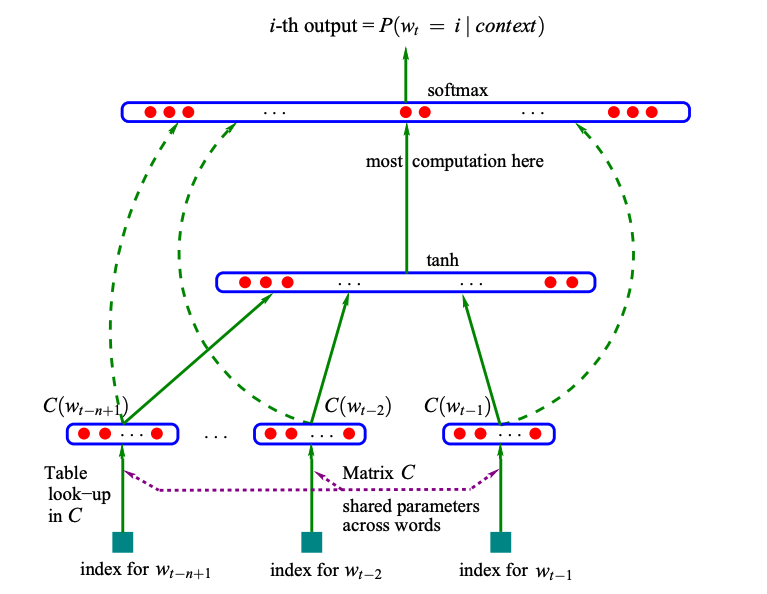

In [1]:
from string import ascii_lowercase

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("mps")
torch.set_default_device(device)
%matplotlib inline

## Dataset 

In [2]:
# Load file and take only the second column, which is called "city_ascii" - so simple city names
# Load file and take only the second column, which is called "city_ascii" - so simple city names
city_names = [row.split(",")[1].replace('"', "") for row in open("worldcities.csv").readlines()][1:]  # don't take header row
city_names[:10]


# Use code below to only use cities from a specific country
# COUNTRY = "finland"
# city_names = []
# rows = [row for row in open("worldcities.csv").readlines()]
# for row in rows:
#   parts = row.split(",")
#   city = parts[1].replace('"', "")
#   country = parts[4].replace('"', "")
#   if country.lower() != COUNTRY:
#     continue
#   else:
#     print(f"{country} -> {city}")
#   city_names.append(city.lower())
#   #city_names = city_names[1:]  # don't take header row's value
# city_names[:10]

['Tokyo',
 'Jakarta',
 'Delhi',
 'Guangzhou',
 'Mumbai',
 'Manila',
 'Shanghai',
 'Sao Paulo',
 'Seoul',
 'Mexico City']

In [3]:
# We need a special characters to denote the start and end of a city name
SPACE = " "
start_end_char = "."
allowed_chars = SPACE + ascii_lowercase
all_chars = start_end_char + allowed_chars

print(f"{ascii_lowercase=}")
print(f"{allowed_chars=}")
print(f"{all_chars=}")

print()

# Clean up the names a little bit
_cities = [name.strip().lower() for name in city_names]

# Remove characters that we don't want to allow
cities = []
for city in _cities:
    clean_city = "".join(ch for ch in city if ch in allowed_chars)
    # print(city, " -> ", clean_city)
    cities.append(clean_city)
    
# Include start/end token
# We don't start city names with "." here anymore, as the context block will be filled with them instead
# cities = [start_end_char + city + start_end_char for city in cities]
cities = [city + start_end_char for city in cities]
print(f"Cleaned up cities: \n{cities[:15]}")

# We will also allow start_end_char
num_classes = len(all_chars)
print(f"Total num valid chars = {num_classes}")

# Create simple mapping between each string char and its integer index
stoi = {c:i for i, c in enumerate(all_chars)}
itos = {i:c for c, i in stoi.items()}

print(f"{stoi=}")
print(f"{itos=}")

ascii_lowercase='abcdefghijklmnopqrstuvwxyz'
allowed_chars=' abcdefghijklmnopqrstuvwxyz'
all_chars='. abcdefghijklmnopqrstuvwxyz'

Cleaned up cities: 
['tokyo.', 'jakarta.', 'delhi.', 'guangzhou.', 'mumbai.', 'manila.', 'shanghai.', 'sao paulo.', 'seoul.', 'mexico city.', 'cairo.', 'new york.', 'dhaka.', 'beijing.', 'kolkata.']
Total num valid chars = 28
stoi={'.': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}
itos={0: '.', 1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z'}


In [4]:
def build_dataset(words, block_size=3):
  """Create samples mapping block_size input to target character."""
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w:
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      
      context = context[1:] + [ix]
      
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [5]:
import random
random.seed(23)
random.shuffle(cities)
num_words = len(cities)
n1 = int(0.8 * num_words)
n2 = int(0.9 * num_words)

WINDOW = 5

Xtr, Ytr = build_dataset(cities[:n1], block_size=WINDOW)
Xdev, Ydev = build_dataset(cities[n1:n2], block_size=WINDOW)
Xte, Yte = build_dataset(cities[n2:], block_size=WINDOW)

torch.Size([358293, 5]) torch.Size([358293])
torch.Size([45224, 5]) torch.Size([45224])
torch.Size([45092, 5]) torch.Size([45092])


In [6]:
Xtr.device, Ytr.device, Xdev.device, Ydev.device

(device(type='mps', index=0),
 device(type='mps', index=0),
 device(type='mps', index=0),
 device(type='mps', index=0))

## Model

### F.cross_entropy()

### Cleaner model code 

In [9]:
g = torch.Generator(device=device).manual_seed(876)

# Create an embedding tensor (latent embedding) for our characters
embedding_dim = 8
C = torch.randn((num_classes, embedding_dim), generator=g)

# Create all model parameters up front
# Now we perform the MLP layer -> embeddings times weight matrix, plus a bias
h_dim = 2048
num_inputs = WINDOW * embedding_dim  # 'window' embeddings per sample + 'embedding_dim' values per embedding
W1 = torch.randn((num_inputs, h_dim), generator=g)  # Shape: (num_inputs, num_neurons)
b1 = torch.randn(h_dim, generator=g)
# Now we can create the final layer and the softmax
W2 = torch.randn((h_dim, num_classes), generator=g)  # W_dim is the incoming latent tensor. num_classes output
b2 = torch.randn(num_classes, generator=g)

parameters = [C, W1, b1, W2, b2]
print(f"Total parameters in model: {sum(p.nelement() for p in parameters)}")

Total parameters in model: 141564


In [10]:
for p in parameters:
  p.requires_grad = True
  print(f"{p.device, p.names}")

(device(type='mps', index=0), (None, None))
(device(type='mps', index=0), (None, None))
(device(type='mps', index=0), (None,))
(device(type='mps', index=0), (None, None))
(device(type='mps', index=0), (None,))


In [11]:
losses = []
batches = []

[     0] loss=86.2238
[ 10000] loss=14.3001
[ 20000] loss=23.4835
[ 30000] loss=15.8068


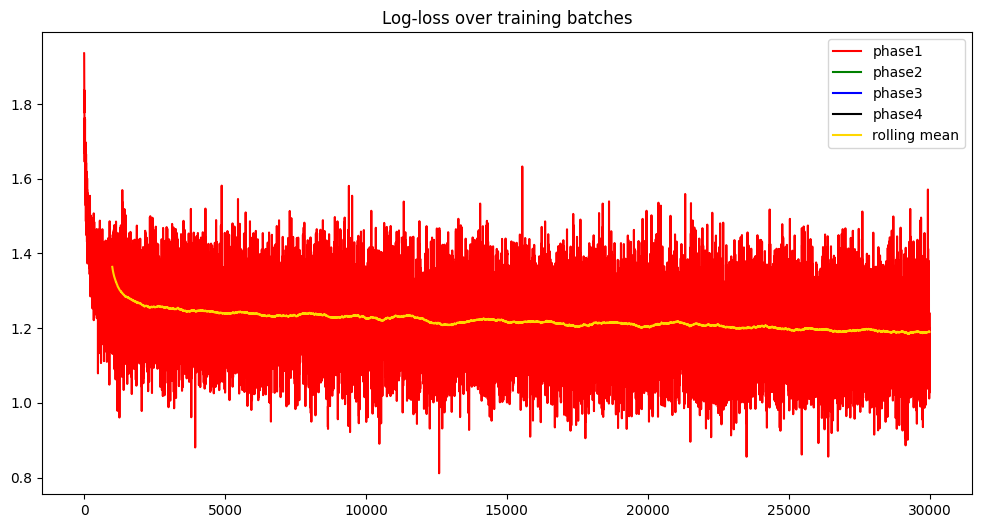

In [12]:
phase1 = 50_000
phase2 = 100_000
phase3 = 150_000
phase4 = 200_000

# Minibatch gradient descent
for batch in range(30_000):
  
  # Create a minibatch
  ix = torch.randint(0, Xtr.shape[0], size=(64,))
  
  emb = C[Xtr[ix]]  # index into the embedding tensor at the position of the training indices

  # Compute the hidden layer transformation and apply non-linearity
  h = torch.tanh(emb.view(-1, WINDOW * embedding_dim) @ W1 + b1)

  logits = h @ W2 + b2  # produces the output of our final layer (no softmax needed)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # Backward pass
  for p in parameters:
    p.grad = None  # Sets gradients to zero before backprop
  loss.backward()

  # Parameter update
  n = len(batches)
  if n < phase1:
    lr = 0.1
  elif n < phase2:
    lr = 0.01
  elif n < phase3:
    lr = 0.005
  elif n < phase4:
    lr = 0.001
  else:
    lr = 0.0001

  for p in parameters:
    p.data += -lr * p.grad

  if batch % 10000 == 0:
    print(f"[{batch:>6}] {loss=:>7.4f}")

  batches.append(batch)
  losses.append(loss.log10().item())

print(f"[{len(batches):>6}] {loss=:>7.4f}")
plt.figure(figsize=(12, 6))
plt.plot(batches[:phase1], losses[:phase1], c="r", label="phase1")
plt.plot(batches[phase1:phase2], losses[phase1:phase2], c="g", label="phase2")
plt.plot(batches[phase2:phase3], losses[phase2:phase3], c="b", label="phase3")
plt.plot(batches[phase3:phase4], losses[phase3:phase4], c="k", label="phase4")
if len(batches) > phase4:
  plt.plot(batches[phase4:], losses[phase4:], c="gray", label="end phase")

rolling_mean = pd.DataFrame(losses, columns=["losses"]).rolling(1000).mean()
plt.plot(batches, rolling_mean.values, c="gold", label="rolling mean")

plt.legend()
plt.title(f"Log-loss over training batches");

[     0] loss=96.3125
[ 10000] loss=11.5436
[ 20000] loss=11.8305
[ 30000] loss=22.9386


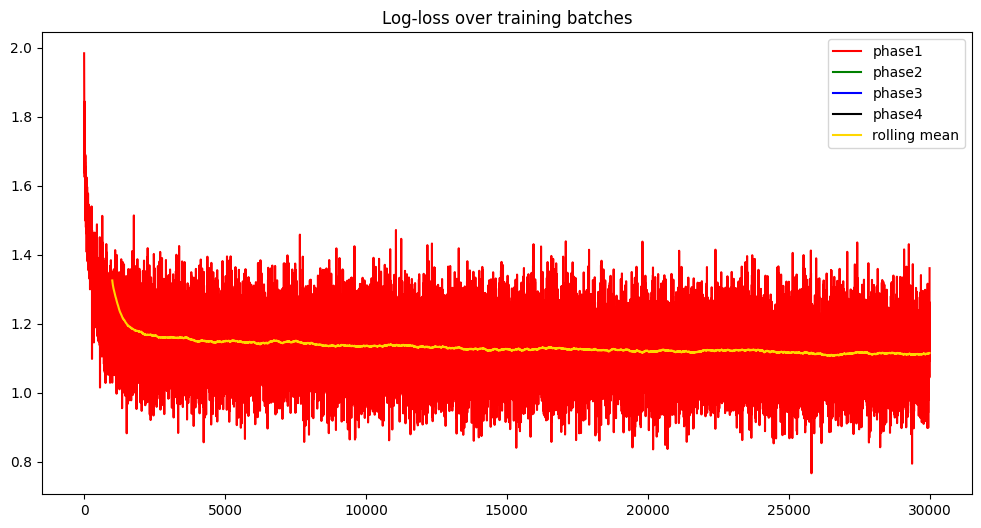

In [17]:
phase1 = 50_000
phase2 = 100_000
phase3 = 150_000
phase4 = 200_000

# Minibatch gradient descent
for batch in range(30_000):
  
  # Create a minibatch
  ix = torch.randint(0, Xtr.shape[0], size=(64,))
  
  emb = C[Xtr[ix]]  # index into the embedding tensor at the position of the training indices

  # Compute the hidden layer transformation and apply non-linearity
  h = torch.tanh(emb.view(-1, WINDOW * embedding_dim) @ W1 + b1)

  logits = h @ W2 + b2  # produces the output of our final layer (no softmax needed)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # Backward pass
  for p in parameters:
    p.grad = None  # Sets gradients to zero before backprop
  loss.backward()

  # Parameter update
  n = len(batches)
  if n < phase1:
    lr = 0.1
  elif n < phase2:
    lr = 0.01
  elif n < phase3:
    lr = 0.005
  elif n < phase4:
    lr = 0.001
  else:
    lr = 0.0001

  for p in parameters:
    p.data += -lr * p.grad

  if batch % 10000 == 0:
    print(f"[{batch:>6}] {loss=:>7.4f}")

  batches.append(batch)
  losses.append(loss.log10().item())

print(f"[{len(batches):>6}] {loss=:>7.4f}")
plt.figure(figsize=(12, 6))
plt.plot(batches[:phase1], losses[:phase1], c="r", label="phase1")
plt.plot(batches[phase1:phase2], losses[phase1:phase2], c="g", label="phase2")
plt.plot(batches[phase2:phase3], losses[phase2:phase3], c="b", label="phase3")
plt.plot(batches[phase3:phase4], losses[phase3:phase4], c="k", label="phase4")
if len(batches) > phase4:
  plt.plot(batches[phase4:], losses[phase4:], c="gray", label="end phase")

rolling_mean = pd.DataFrame(losses, columns=["losses"]).rolling(1000).mean()
plt.plot(batches, rolling_mean.values, c="gold", label="rolling mean")

plt.legend()
plt.title(f"Log-loss over training batches");

In [10]:
# loss on full training set
emb = C[Xdev]  # index into the embedding tensor at the position of the training indices
h = torch.tanh(emb.view(-1, WINDOW * embedding_dim) @ W1 + b1)
logits = h @ W2 + b2  # computes the output of our final hidden layer
loss = F.cross_entropy(input=logits, target=Ydev)  # Compute the loss (posed as binary classification)
print(f"Full dev set loss: {loss:.6f}")

Full dev set loss: 2.523684


In [11]:
# loss on full training set
emb = C[Xtr]  # index into the embedding tensor at the position of the training indices
h = torch.tanh(emb.view(-1, WINDOW * embedding_dim) @ W1 + b1)
logits = h @ W2 + b2  # computes the output of our final hidden layer
loss = F.cross_entropy(input=logits, target=Ytr)  # Compute the loss (posed as binary classification)
print(f"Full train set loss: {loss:.6f}")

Full train set loss: 2.487757


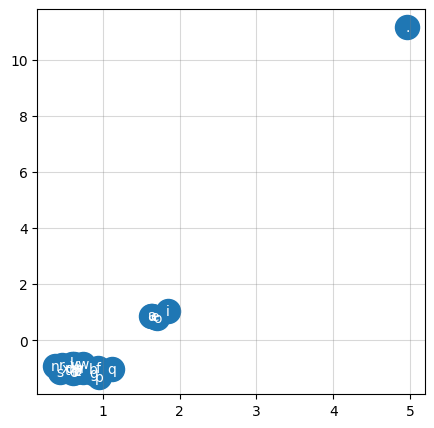

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=300)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), s=itos[i], ha="center", va="center", color="white", size=10)

plt.grid(color="gray", alpha=0.3)

### Inference

In [13]:
for i in range(20): 
    
  ix = stoi[start_end_char]
  context = [ix] * WINDOW
  new_word = []

  while True:
    emb = C[torch.tensor([context])]  # shape (1, window, embedding)  (1, 5, 2)
    h = torch.tanh(emb.view(1, WINDOW * embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    ch = itos[ix]
    if ch == start_end_char:
      break
    new_word.append(ch)
    context = context[1:] + [ix]

  gen_city = ''.join(new_word)
  print(f"[Word {i:>2}]: {gen_city:<20} -- in dataset: {(gen_city + start_end_char) in cities}")

[Word  0]: dan jorsk            -- in dataset: False
[Word  1]: srhitskel            -- in dataset: False
[Word  2]: culripe              -- in dataset: False
[Word  3]: ordayringer          -- in dataset: False
[Word  4]: abaldamurzatuwnoada  -- in dataset: False
[Word  5]: naranbi              -- in dataset: False
[Word  6]: dotracollalevlal     -- in dataset: False
[Word  7]: gangeia              -- in dataset: False
[Word  8]: gundiri              -- in dataset: False
[Word  9]: dusringen            -- in dataset: False
[Word 10]: dutrlawostarari      -- in dataset: False
[Word 11]: traer                -- in dataset: False
[Word 12]: kamod dainyui        -- in dataset: False
[Word 13]: poiras               -- in dataset: False
[Word 14]: anpana               -- in dataset: False
[Word 15]: narlebiur            -- in dataset: False
[Word 16]: balpsadala           -- in dataset: False
[Word 17]: zirim                -- in dataset: False
[Word 18]: farms                -- in dataset: